#### Goals
The goals are to first:
1. get ode parameter estimation working with GPR. On one biomarker curve, with known timepoints.
2. expand to multiple patients with multiple biomarkers. 
3. using synthetic patients and no known timepoints, find time parameters of each observation with respect to the biomarkers.

## 1. ODE Parameter Fitting using LSQ


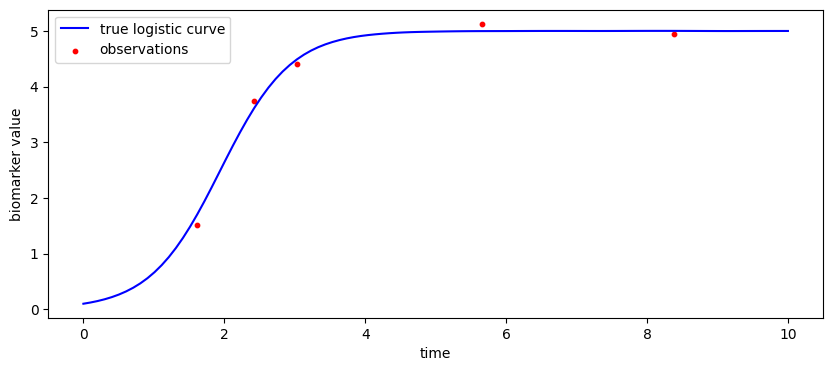

In [37]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Logistic ode defines the progression of our biomarker
def logistic_ODE(t, y, k=1, a=1):
    return (k / a) * y * (a - y)

# ground truth
a_true = 5  # I dont know
k_true = 2  # steepness
y0_true = 0.1  # inflection point

t_eval = np.linspace(0, 10, 100)

# solve
sol = solve_ivp(logistic_ODE, t_span=(min(t_eval), max(t_eval)),
    y0=[y0_true], args=(k_true, a_true), t_eval=t_eval, method="RK45")

# additive noise
np.random.normal(0, 0.1, size=sol.y[0].shape)

num_obs = 5 # think about this as number of patient scans

np.random.seed(2)
random_idx = np.random.choice(np.arange(len(sol.t)), size=num_obs, replace=False)
random_idx = np.sort(random_idx)

t_obs = sol.t[random_idx]
y_obs = sol.y[0][random_idx] + np.random.normal(0, 0.1, size=sol.y[0][random_idx].shape)

# truth plot
plt.figure(figsize=(10, 4))
plt.plot(sol.t, sol.y[0], label="true logistic curve", color="blue")
plt.scatter(t_obs, y_obs, label="observations", color="red", s=10)
plt.xlabel("time")
plt.ylabel("biomarker value")
plt.legend()
plt.show()

Implementing LSQ fitting by taking in a parameter "guess", to feed into our ODE, then we evaluate our guess against the observations accordingly to minimize residuals.

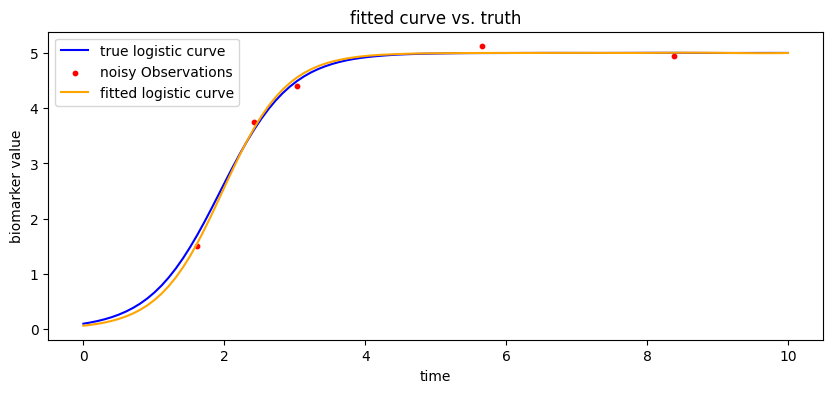

2.2038798481644486
4.999740731674547
0.06317439044930248


In [40]:

def lsq_ODE(params, t_obs, y_obs, f_ODE=logistic_ODE):
    """
    Takes in a ODE function, with an array of guesses for each parameter.
    Computes ODE using guesses and then computes residuals using observations
    to be used in optimization.
    
    Returns:
    - residuals (np.ndarray): difference between predicted and observed
    """
    k, a, y0 = params
    # solve the ODE with the current parameter guesses
    sol = solve_ivp(f_ODE, t_span=(min(t_obs), max(t_obs)), 
        y0=[y0], args=(k, a), t_eval=t_obs,method="RK45",
    )
    # compute residuals
    return y_obs - sol.y[0][random_idx]

# def lsq_ODE(params, x, data, f_ODE=logistic_ODE):
#
#     y0_ode = params['y0_ode'].value
#     args_ode = []
#     for key in params.keys():
#         if key != 'y0_ode':
#             args_ode.append(params[key].value)
#     args_ode = tuple(args_ode)    
#     sol = solve_ivp(f_ODE, t_span=(min(x),max(x)), y0 = [y0_ode], args=args_ode, t_eval = x, method='DOP853')     
#     return data - sol.y

# min1 = minimize(lsq_ODE, params = params, args=(t_eval, sig), ftol=1e-20, gtol=1e-20, xtol=1e-20, max_nfev=20000) # fcn_kws= {'x':t_eval,'data': sig})#, 'f_ODE': logistic_ODE})
# report_fit(min1)

# initial parameter guesses
params_guess = [1e-2, 40, 0.2]  # [k, a, y0]

# Optimize parameters using least squares
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html#scipy.optimize.minimize
# https://stackoverflow.com/questions/18985048/error-using-l-bfgs-b-in-scipy
# https://www.youtube.com/watch?v=G0yP_TM-oag intro video

result = minimize(
    lambda p: np.sum(lsq_ODE(p, t_eval, y_obs) ** 2), params_guess,
    method="L-BFGS-B", bounds=[(0.1, 10), (0.1, 10), (0, 5)])
# using L-BFGS-B minimizer to use bounds

# extract fitted parameters
k_fit, a_fit, y0_fit = result.x

# solve ODE but with fitted parameters
sol_fit = solve_ivp(logistic_ODE, t_span=(min(t_eval), max(t_eval)),
    y0=[y0_fit], args=(k_fit, a_fit), t_eval=t_eval, method="RK45")

# Plot results
plt.figure(figsize=(10, 4))
plt.plot(sol.t, sol.y[0], label="true logistic curve", color="blue")
plt.scatter(t_obs, y_obs, label="noisy Observations", color="red", s=10)
plt.plot(sol_fit.t, sol_fit.y[0], label="fitted logistic curve", color="orange")
plt.xlabel("time")
plt.ylabel("biomarker value")
plt.legend()
plt.title("fitted curve vs. truth")
plt.show()

print(k_fit)
print(a_fit)
print(y0_fit)


## 2. Gaussian Process Regression (GPR) Sklearn demo
A gaussian process is a type of stochastic process which is a set of random variables that are indexed over time or defined over time, and usually has this notation ${\displaystyle \{X(t)\}_{t\in T}}$ or just $X_{t}$.

A Gaussian process is usually notated like this:
$$f(x) \sim GP(m(x), k(x,x'))$$

Where f(**x**) is not just a function, its a real process, and m(**x**) is the mean function which is just E(f(x)), (the GP people usually set it equal to 0), and k(**x**,**x**') is the covariance function, which defines how related the real process is to its derivative.

Let's start with a very simple demo of GPR, on an individual with one biomarker and then we will layer on complexity. This demo is from: https://scikit-learn.org/1.5/auto_examples/gaussian_process/plot_gpr_noisy_targets.html. This GPR demo will estimate the function that defines the set of points given to the GPR, later we will modify it to fit ODE parameters.

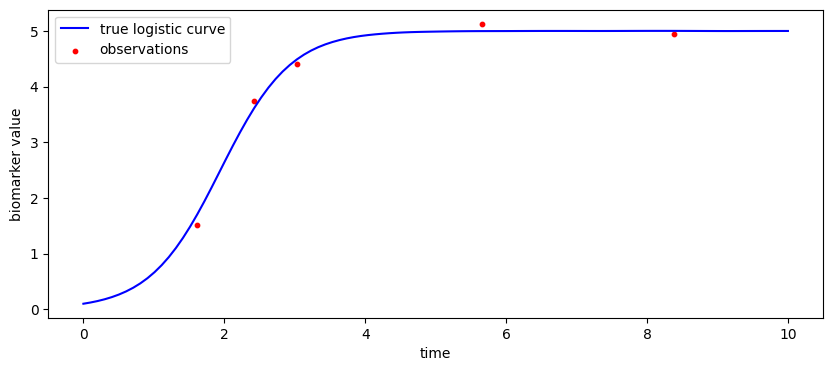

In [27]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# Logistic ode defines the progression of our biomarker
def logistic_ODE(t, y, k=1, a=1):
    return (k / a) * y * (a - y)

# ground truth
a_true = 5  # I dont know
k_true = 2  # steepness
y0_true = 0.1  # inflection point

t_eval = np.linspace(0, 10, 100)

# solve
sol = solve_ivp(logistic_ODE, t_span=(min(t_eval), max(t_eval)),
    y0=[y0_true], args=(k_true, a_true), t_eval=t_eval, method="RK45")

num_obs = 5 # think about this as number of patient scans
np.random.seed(2)
random_idx = np.random.choice(np.arange(len(sol.t)), size=num_obs, replace=False)
random_idx = np.sort(random_idx)

t_obs = sol.t[random_idx]
y_obs = sol.y[0][random_idx] + np.random.normal(0, 0.1, size=sol.y[0][random_idx].shape)

# truth plot
plt.figure(figsize=(10, 4))
plt.plot(sol.t, sol.y[0], label="true logistic curve", color="blue")
plt.scatter(t_obs, y_obs, label="observations", color="red", s=10)
plt.xlabel("time")
plt.ylabel("biomarker value")
plt.legend()
plt.show()

In [37]:
X = t_eval.reshape(-1,1)
y = sol.y[0].reshape(-1,1)

rng = np.random.RandomState(2)
random_idx = rng.choice(np.arange(y.size), size=5, replace=False)
X_train, y_train = X[random_idx], y[random_idx]

In [38]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gaussian_process.fit(X_train, y_train)
gaussian_process.kernel_

mean_prediction, std_prediction = gaussian_process.predict(X, return_std=True)

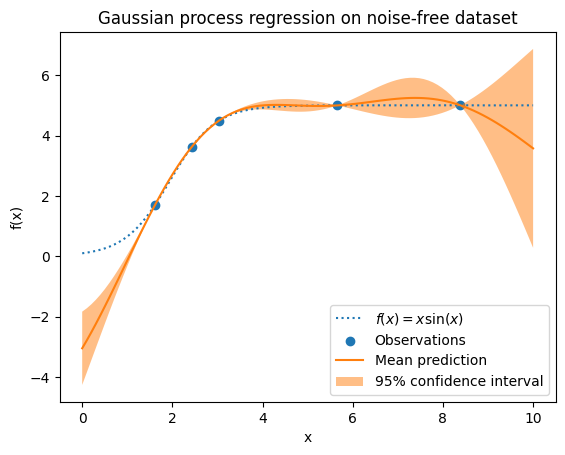

In [39]:

plt.plot(X, y, label=r"$f(x) = x \sin(x)$", linestyle="dotted") # U CAN USE LATEX IN PYTHON????
plt.scatter(X_train, y_train, label="Observations")
plt.plot(X, mean_prediction, label="Mean prediction")
plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.5,
    label=r"95% confidence interval",
)
plt.legend()
plt.xlabel("x")
plt.ylabel("f(x)")
_ = plt.title("Gaussian process regression on noise-free dataset")

**This is not at all what we want to do!** But this is just to get an idea about basic gaussian process implementation using sklearn. We are assuming that biomarkers progress in a logistic way, therefore we would like our output to be sigmoidal. **We want to use GP regression to find the parameters of our disease biomarker.** However it should be noted, that later on we will want to remove any time related data from the training data and predict a time shift, becuase that is truly unknown to us, but we will cross that bridge once we get there. For now there will be time

## 3. GPR Parameter estimation.
Now the question is can we produce the same type of outcome using GPR as the LSQ optimization to recover our biomarker progression.

#### outline of implementation
1. define ground truth and randomly sample different timepoints (define X_train and y_train).
2. train GPR model, fit model onto observations and predict mean and CI over time range.
3. Use the mean function from GPR, and mean function of guessed parameters to compute residuals: $$m_{observed}(x) - g(x) | m_{observed}(x) - m_{guess}(x)$$
4. minimize residual
5. plot fitted results. 

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

# Logistic ode defines the progression of our biomarker
def logistic_ODE(t, y, k=1, a=1):
    return (k / a) * y * (a - y)

# ground truth
a_true = 5
k_true = 2  # steepness
y0_true = 0.1  # inflection point

t_eval = np.linspace(0, 10, 100)

# solve
sol = solve_ivp(logistic_ODE, t_span=(min(t_eval), max(t_eval)),
    y0=[y0_true], args=(k_true, a_true), t_eval=t_eval, method="RK45")

num_obs = 5 # think about this as number of patient scans
np.random.seed(2)
random_idx = np.random.choice(np.arange(len(sol.t)), size=num_obs, replace=False)
random_idx = np.sort(random_idx)

t_obs = sol.t[random_idx].reshape(-1,1)
y_obs = sol.y[0][random_idx] + np.random.normal(0, 0.1, size=sol.y[0][random_idx].shape)

X_train, y_train = t_obs, y_obs

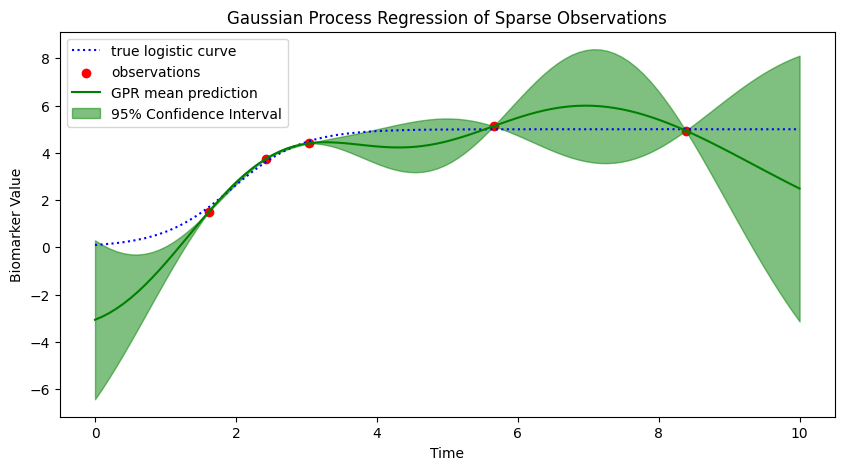

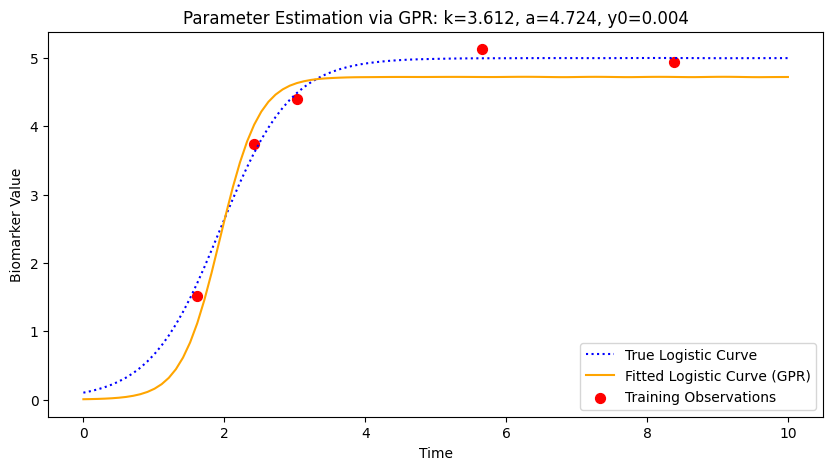

In [4]:
# get mean and std, by training a GP on observations.
# f(x) ~ GP(m(x), std(x,x'))
kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gpr = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10)
gpr.fit(X_train, y_train)

# predict over the full range of time, just like in sklearn demo
X = t_eval.reshape(-1, 1)
mean_prediction, std_prediction = gpr.predict(X, return_std=True)

plt.figure(figsize=(10, 4))
plt.plot(sol.t, sol.y[0], label="true logistic curve", color="blue", linestyle="dotted")
plt.scatter(X_train, y_train, label="observations", color="red")
plt.plot(X, mean_prediction, label="GPR mean prediction", color="green")
plt.fill_between(
    X.ravel(),
    mean_prediction - 1.96 * std_prediction,
    mean_prediction + 1.96 * std_prediction,
    alpha=0.5,
    label="95% Confidence Interval",
    color="green",
)
plt.xlabel("time")
plt.ylabel("biomarker value")
plt.legend()
plt.title("GP of biomarker observations w/ known time.")
plt.show()

# everything is good so far, now just need to minimize above with a guess
# Define the objective function for GPR-based parameter fitting

# k = param[0]
# a = param[1]
# y0 = param[2]

def gpr_objective(params):
    k, a, y0 = params
    sol = solve_ivp(
        logistic_ODE,
        t_span=(min(t_eval), max(t_eval)),
        y0=[y0],
        args=(k, a),
        t_eval=t_eval,
        method="RK45",
    )
    return np.sum((mean_prediction.flatten() - sol.y[0]) ** 2)

# Initial guesses for parameters
params_guess = [1, 4, 0.2]

# Optimize parameters using GPR
result_gpr = minimize(
    gpr_objective,
    params_guess,
    method="L-BFGS-B",
    bounds=[(0.1, 10), (0.1, 10), (0, 5)],
)

# Extract fitted parameters
k_fit_gpr, a_fit_gpr, y0_fit_gpr = result_gpr.x

sol_fit_gpr = solve_ivp(
    logistic_ODE,
    t_span=(min(t_eval), max(t_eval)),
    y0=[y0_fit_gpr],
    args=(k_fit_gpr, a_fit_gpr),
    t_eval=t_eval,
    method="RK45",
)

plt.figure(figsize=(10, 4))
plt.plot(sol.t, sol.y[0], label="True Logistic Curve", color="blue", linestyle="dotted")
plt.plot(sol_fit_gpr.t, sol_fit_gpr.y[0], label="Fitted Logistic Curve (GPR)", color="orange")
plt.scatter(X_train, y_train, label="Training Observations", color="red", s=50)
plt.xlabel("Time")
plt.ylabel("Biomarker Value")
plt.legend()
plt.title(
    f"Parameter Estimation via GPR: k={k_fit_gpr:.3f}, a={a_fit_gpr:.3f}, y0={y0_fit_gpr:.3f}"
)
plt.show()


This solution is pretty shitty, and having to solve many ivp's might be scalable. Also, let's try to move towards a model that better mirrors the problem at hand, and thats that **we do not have time data**, and that there are many biomarkers and we don't know in what order they progress from healthy --> unhealthy.

#### Regarding time
We not only need to know the characteristics of the logistic curve that define a biomarkers progression but also the time in which it takes place. Therefore we need to incorporate some kind of timeshift variable to give the biomarker some temporal context relative to other biomarkers.

#### Adding multiple biomarkers
For now I might keep the biomarkers independant, but it would be worth coming back to add some dependency such as the connectome which could be used as a prior later down the line.

#### Probabilistic component
There needs to be a probabalistic component as a through line through out the creation of the model. There likely has to be some kind of bayesian approach to both parameter estimation AND progression order (time shifts)

Although im not sure if order would be the correct term since we are in a more continuous context.

#### Ordering patients
Im going to have to come back to this. 

#### Final note
!! - Let us not for get that the Logistic ODE solves for dy/dt, where as just a regular logistic logistic function is the analytical solution to the ODE, and solves for y(t)

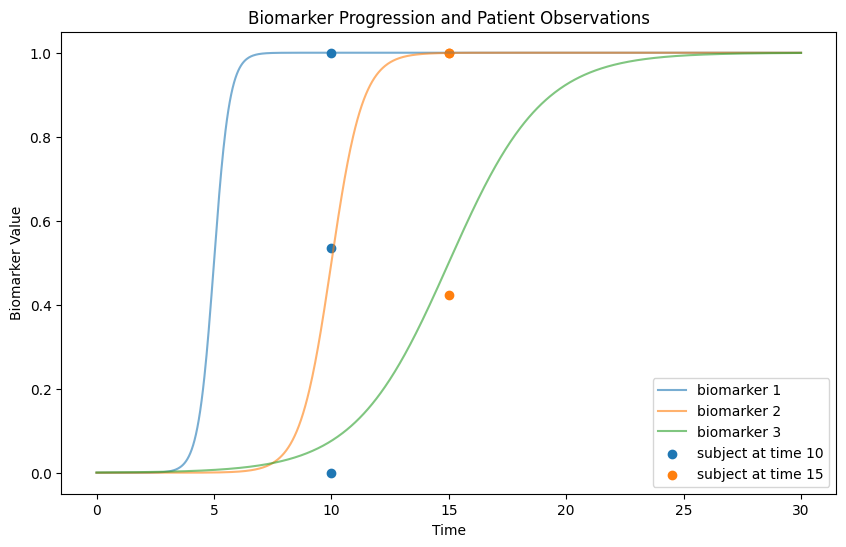

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# this is just a continuous version of anvar's code, i.e. stages ---> time

def logistic_function(t, k=1, t0=0):
    """Logistic function with y = [0, 1]."""
    return 1 / (1 + np.exp(-k * (t - t0)))

def generate_patient(time, biomarkers: dict, random_state=None, noise=False):
    """    
    Generates vector of patient biomarkers given patient time and dictionary of biomarkers' parameters. 
    Adds small noise (with fixed mu, std) to biomarkers.
    """
    random = np.random.RandomState(random_state)
    values = []
    for marker, parameters in biomarkers.items():
        k = parameters['k']
        t0 = parameters['t0']
        value = logistic_function(time, k, t0)
        if noise:
            value += random.normal(0, 0.05)
        value = np.clip(value, 0, 1) # clip values to keep biomarkers' value bounded to [0,1]
        values.append(value)
    return np.array(values)

# define each biomarker and their parameters
biomarkers = {
    1: {'k': 3, 't0': 5},
    2: {'k': 1.5, 't0': 10},
    3: {'k': 0.5, 't0': 15}
}

# Generate progression curves
time = np.linspace(0, 30, 1000)
y1 = logistic_function(time, biomarkers[1]['k'], biomarkers[1]['t0'])
y2 = logistic_function(time, biomarkers[2]['k'], biomarkers[2]['t0'])
y3 = logistic_function(time, biomarkers[3]['k'], biomarkers[3]['t0'])

# generate patient biomarker values
example1 = generate_patient(10, biomarkers, random_state=10, noise=True)
example2 = generate_patient(15, biomarkers, random_state=10, noise=True)

plt.figure(figsize=(10, 6))
plt.plot(time, y1, label="biomarker 1", alpha=0.6)
plt.plot(time, y2, label="biomarker 2", alpha=0.6)
plt.plot(time, y3, label="biomarker 3", alpha=0.6)
plt.scatter([10] * 3, example1, label="subject at time 10")
plt.scatter([15] * 3, example2, label="subject at time 15")
plt.xlabel("Time")
plt.ylabel("Biomarker Value")
plt.legend()
plt.title("Biomarker Progression and Patient Observations")
plt.show()

This is where the fun really begins, because now we have a the ability to generate a sample of patients at various times. We should probably to the thing where we have a distribution of patients that are healthy and unhealthy, and determine some kind of threshold for an individual biomarker going from healthy to unhealthy.

In [21]:
num_patients = 200
num_biomarkers = len(biomarkers)
time_range = (0, 30) # all patients are observed in this time range.

observation_times = np.random.uniform(*time_range, size=num_patients)
patient_data = np.zeros((num_patients, num_biomarkers))

for i, time in enumerate(observation_times):
    patient_data[i] = generate_patient(time, biomarkers, noise=True)

print(observation_times[:10])
print("head:")
print(patient_data[:5])

[14.73287188 27.81331887  3.16179654 22.93322184 12.2901316  19.65521144
  7.80709794  4.78476788  4.81387843  2.11475837]
head:
[[0.95026771 0.99761744 0.42975337]
 [1.         0.89379546 0.99457171]
 [0.         0.         0.01983157]
 [0.97688992 0.99391498 1.        ]
 [1.         0.90802007 0.22454433]]
